In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import time
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pandas_udf, udf

In [5]:
spark = SparkSession.builder \
    .appName("API_Enhancement_Tests_Spark3") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

# Enable Adaptive Query Execution (AQE)
spark.conf.set("spark.sql.adaptive.enabled", "true")

# Set Arrow batch size (NEW CONFIG)
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "50000")


Spark version: 3.0.2


## API Benchmark Test Design

In [6]:
# 1. DataFrame Operations Tests
# Performance measurement function
def measure_execution(operation_name, func):
    start_time = time.time()
    result = func()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Operation: {operation_name}, Execution time: {execution_time:.4f} seconds")
    return result, execution_time

# Create sample data
def create_test_data(spark, num_records=10**6):
    data = [(i, f"name_{i}", i % 100, i % 5) for i in range(num_records)]
    df = spark.createDataFrame(data, ["id", "name", "value", "category"])
    return df

test_df = create_test_data(spark)

results = []

# Test 1: Basic Filtering
filter_op, filter_time = measure_execution(
    "Basic filtering",
    lambda: test_df.filter(F.col("value") > 50).count()
)
results.append(("Basic filtering", filter_time))

# Test 2: Grouping and Aggregation
group_op, group_time = measure_execution(
    "Grouping and aggregation",
    lambda: test_df.groupBy("category").agg(F.avg("value").alias("avg_value")).collect()
)
results.append(("Grouping and aggregation", group_time))

# Test 3: Window Functions
window_op, window_time = measure_execution(
    "Window functions",
    lambda: test_df.withColumn(
        "rank",
        F.rank().over(Window.partitionBy("category").orderBy(F.desc("value")))
    ).collect()
)
results.append(("Window functions", window_time))


Operation: Basic filtering, Execution time: 10.9426 seconds
Operation: Grouping and aggregation, Execution time: 8.6843 seconds
Operation: Window functions, Execution time: 14.5892 seconds


In [7]:
# ------------------ Pandas UDFs Optimization ------------------
# Process only a subset (reduce memory footprint)
pandas_df = test_df.limit(100000)  # Reduce the dataset for Pandas UDFs

# Optimized Pandas UDF (Vectorized Series to Series)
@pandas_udf(IntegerType())
def square_udf(v: pd.Series) -> pd.Series:
    return v * v

pandas_udf_op, pandas_udf_time = measure_execution(
    "Pandas UDF (Series to Series)",
    lambda: pandas_df.select(square_udf(F.col("value")).alias("value_squared")).collect()
)
results.append(("Pandas UDF (Series to Series)", pandas_udf_time))

# Standard UDF (for comparison)
standard_udf = udf(lambda x: x * x, IntegerType())

std_udf_op, std_udf_time = measure_execution(
    "Standard UDF",
    lambda: pandas_df.select(standard_udf(F.col("value")).alias("value_squared")).collect()
)
results.append(("Standard UDF", std_udf_time))

# ------------------ Grouped Pandas UDF ------------------
@pandas_udf(DoubleType())
def mean_udf(v: pd.Series) -> float:
    return v.mean()

grouped_udf_op, grouped_udf_time = measure_execution(
    "Grouped Pandas UDF",
    lambda: pandas_df.groupBy("category").agg(mean_udf(F.col("value")).alias("mean_value")).collect()
)
results.append(("Grouped Pandas UDF", grouped_udf_time))

# ------------------ Store Results ------------------
performance_results = pd.DataFrame(results, columns=["Operation", "Execution Time (s)"])
print(performance_results)

Operation: Pandas UDF (Series to Series), Execution time: 10.5487 seconds
Operation: Standard UDF, Execution time: 8.8697 seconds
Operation: Grouped Pandas UDF, Execution time: 9.7720 seconds
                       Operation  Execution Time (s)
0                Basic filtering           10.942605
1       Grouping and aggregation            8.684344
2               Window functions           14.589168
3  Pandas UDF (Series to Series)           10.548670
4                   Standard UDF            8.869698
5             Grouped Pandas UDF            9.771958


In [8]:
from pyspark.sql.functions import udf, pandas_udf
import pandas as pd
import numpy as np
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window

# Use a smaller dataset to avoid memory crashes
complex_test_df = test_df.limit(100000)

# ------------------ 1️⃣ Standard UDF ------------------
@udf(DoubleType())
def standard_complex_transform(x):
    return float((x ** 2 + np.log10(x + 1)) / np.sqrt(x + 1))

# ------------------ 2️⃣ Pandas UDF ------------------
@pandas_udf(DoubleType())
def pandas_complex_transform(v: pd.Series) -> pd.Series:
    return v.apply(lambda x: float((x ** 2 + np.log10(x + 1)) / np.sqrt(x + 1)))

# ------------------ 3️⃣ Grouped Pandas UDF ------------------
@pandas_udf(DoubleType())
def grouped_pandas_complex(v: pd.Series) -> float:
    return float((v ** 2 + np.log10(v + 1)).mean())  # Convert mean result to float

# ------------------ Benchmarking ------------------
results = []

# Standard UDF
standard_udf_op, standard_udf_time = measure_execution(
    "Standard UDF (Complex Transform)",
    lambda: complex_test_df.select(standard_complex_transform(F.col("value")).alias("complex_result")).collect()
)
results.append(("Standard UDF (Complex Transform)", standard_udf_time))

# Pandas UDF
pandas_udf_op, pandas_udf_time = measure_execution(
    "Pandas UDF (Complex Transform)",
    lambda: complex_test_df.select(pandas_complex_transform(F.col("value")).alias("complex_result")).collect()
)
results.append(("Pandas UDF (Complex Transform)", pandas_udf_time))

# Grouped Pandas UDF
grouped_pandas_udf_op, grouped_pandas_udf_time = measure_execution(
    "Grouped Pandas UDF (Mean Complex Transform per Category)",
    lambda: complex_test_df.groupBy("category").agg(grouped_pandas_complex(F.col("value")).alias("mean_complex")).collect()
)
results.append(("Grouped Pandas UDF (Mean Complex Transform per Category)", grouped_pandas_udf_time))

# Display Results
performance_results = pd.DataFrame(results, columns=["Operation", "Execution Time (s)"])
print(performance_results)


Operation: Standard UDF (Complex Transform), Execution time: 10.4632 seconds
Operation: Pandas UDF (Complex Transform), Execution time: 10.6955 seconds
Operation: Grouped Pandas UDF (Mean Complex Transform per Category), Execution time: 9.4651 seconds
                                           Operation  Execution Time (s)
0                   Standard UDF (Complex Transform)           10.463181
1                     Pandas UDF (Complex Transform)           10.695472
2  Grouped Pandas UDF (Mean Complex Transform per...            9.465062


In [9]:
# 3. Type Hints and API Ergonomics Tests
# For Spark 3.x
# Type hints in Spark 3.x using 'sql' module
from pyspark.sql import SparkSession

data = [("Alice", 25), ("Bob", 30)]
df_typed = spark.createDataFrame(data, schema=["name: string", "age: int"])

In [10]:
# 4. API Usage Metrics
# Track API usage metrics
api_metrics = []

import ast

# Spark 2.x Code (More Verbose)
spark2_code = """
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True)
])

data = [("Alice", 25), ("Bob", 30)]
df_manual_schema = spark.createDataFrame(data, schema)
"""
# Spark 3.x Code (With Type Hints, Optimized for Fewer Lines)
spark3_code = """
from pyspark.sql import SparkSession

data = [("Alice", 25), ("Bob", 30)]
df_typed = spark.createDataFrame(data, schema=["name: string", "age: int"])
"""

def count_code_lines(code_string):
    """Counts the number of executable statements in a code string."""
    tree = ast.parse(code_string)  # Parse code
    return sum(isinstance(node, ast.stmt) for node in ast.walk(tree))

# Count lines again
code_lines_spark2 = count_code_lines(spark2_code)
code_lines_spark3 = count_code_lines(spark3_code)

# Store API Metrics
api_metrics = [{
    "Operation": "Type Hints & Schema Definition",
    "Code Lines Spark 2.x": code_lines_spark2,
    "Code Lines Spark 3.x": code_lines_spark3,
    "Reduction (%)": round((1 - code_lines_spark3/code_lines_spark2) * 100, 2)
}]

# Create DataFrame
df_api_metrics = pd.DataFrame(api_metrics)

# Display the table properly in Jupyter Notebook
display(df_api_metrics)


,Operation,Code Lines Spark 2.x,Code Lines Spark 3.x,Reduction (%)
0,Type Hints & Schema Definition,4,3,25.0


In [11]:
# ------------------ Spark 3.x Dataset API Test (100M Rows) ------------------
import time
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col
from typing import List

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Dataset API Test - Spark 3.x") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Define Dataset Using Type Hints
class Person(Row):
    name: str
    age: int

# Generate Large Dataset Using Type Hinting (100M Rows)
NUM_RECORDS = 10**8  # 100 million rows
people: List[Person] = [Person(name=f"Person_{i}", age=i % 100) for i in range(10**6)]  # Generate 1M at a time

# Convert to DataFrame (Simulating Dataset API in PySpark)
df_spark3 = spark.createDataFrame(people)

# Apply Dataset-style Filtering Operation
start_time = time.time()
df_spark3_filtered = df_spark3.filter(col("age") > 30).count()
end_time = time.time()

# Print Execution Time
spark3_time = round(end_time - start_time, 4)
print(f"Spark 3.x Execution Time: {spark3_time} seconds")

# Stop Spark Session
spark.stop()


Spark 3.x Execution Time: 7.9415 seconds


## Specific Tests

In [12]:
# Ensure findspark is initialized (only needed if running outside a Spark environment)
import findspark
findspark.init()

# Import Spark modules
from pyspark.sql import SparkSession

# Stop any existing Spark session (Avoid conflicts)
try:
    spark.stop()
except:
    pass  # Ignore errors if Spark was not running

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("DataFrame Transformations Test") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print(f"Spark version: {spark.version}")


Spark version: 3.0.2


In [13]:
# 1. DataFrame Transformations (Spark 3.x)
import time
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Initialize Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Stop existing session & start a new one
try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("DataFrame Transformations Test - Spark 3.x") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

# Measure execution function
def measure_execution(operation_name, func):
    start_time = time.time()
    result = func()
    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Operation: {operation_name}")
    print(f"  Execution time: {execution_time:.4f} seconds")

    return {
        "operation": operation_name,
        "execution_time": execution_time
    }

# Create test data function
def create_test_data(spark, size=100000):
    data = [(i, f"name_{i}", i % 100, i % 5) for i in range(size)]
    df = spark.createDataFrame(data, ["id", "name", "value", "category"])
    return df

# Run test
test_df = create_test_data(spark, size=1000000)
print("Test DataFrame created successfully!")


Spark version: 3.0.2
Test DataFrame created successfully!


In [17]:
# # 2. Specific DataFrame Transformation Tests
# Test: Column operations
# Enable AQE
spark.conf.set("spark.sql.adaptive.enabled", "true")

# Run tests and store results dynamically
aqe_enabled_results = {}

aqe_enabled_results["Column operations"] = measure_execution(
    "Column operations", 
    lambda: test_df.withColumn("value_squared", F.col("value") * F.col("value"))
             .withColumn("category_str", F.concat(F.lit("Category: "), F.col("category").cast("string")))
             .select("id", "name", "value_squared", "category_str")
             .cache()
             .count()
)["execution_time"]

# Test: Complex aggregations
aqe_enabled_results["Complex aggregations"] = measure_execution(
    "Complex aggregations", 
    lambda: test_df.groupBy("category")
             .agg(
                 F.count("id").alias("count"),
                 F.sum("value").alias("total_value"),
                 F.avg("value").alias("avg_value"),
                 F.min("value").alias("min_value"),
                 F.max("value").alias("max_value"),
                 F.expr("percentile(value, 0.5)").alias("median_value")
             )
             .orderBy("category")
             .collect()
)["execution_time"]

# Test: Window functions
aqe_enabled_results["Window functions"] = measure_execution(
    "Window functions", 
    lambda: test_df.withColumn(
                "rank", F.rank().over(Window.partitionBy("category").orderBy(F.desc("value")))
             )
             .withColumn(
                "running_total", F.sum("value").over(Window.partitionBy("category").orderBy("id").rowsBetween(Window.unboundedPreceding, 0))
             )
             .where(F.col("rank") <= 10)
             .orderBy("category", "rank")
             .cache()
             .count()
)["execution_time"]

# Test: Join operations
aqe_enabled_results["Join operations"] = measure_execution(
    "Join operations", 
    lambda: spark.createDataFrame(
            [(i % 5, f"cat_{i % 5}") for i in range(5)],
            ["category", "category_name"]
        ).join(
            test_df,
            on="category",
            how="inner"
        )
        .groupBy("category_name")
        .agg(F.count("*").alias("count"), F.avg("value").alias("avg_value"))
        .collect()
)["execution_time"]


Operation: Column operations
  Execution time: 0.2174 seconds
Operation: Complex aggregations
  Execution time: 9.3968 seconds
Operation: Window functions
  Execution time: 0.1381 seconds
Operation: Join operations
  Execution time: 16.8810 seconds


In [15]:
# Disable AQE
spark.conf.set("spark.sql.adaptive.enabled", "false")

# Run tests and store results dynamically
aqe_disabled_results = {}

aqe_disabled_results["Column operations"] = measure_execution(
    "Column operations", 
    lambda: test_df.withColumn("value_squared", F.col("value") * F.col("value"))
             .withColumn("category_str", F.concat(F.lit("Category: "), F.col("category").cast("string")))
             .select("id", "name", "value_squared", "category_str")
             .cache()
             .count()
)["execution_time"]

aqe_disabled_results["Complex aggregations"] = measure_execution(
    "Complex aggregations", 
    lambda: test_df.groupBy("category")
             .agg(
                 F.count("id").alias("count"),
                 F.sum("value").alias("total_value"),
                 F.avg("value").alias("avg_value"),
                 F.min("value").alias("min_value"),
                 F.max("value").alias("max_value"),
                 F.expr("percentile(value, 0.5)").alias("median_value")
             )
             .orderBy("category")
             .collect()
)["execution_time"]

aqe_disabled_results["Window functions"] = measure_execution(
    "Window functions", 
    lambda: test_df.withColumn(
                "rank", F.rank().over(Window.partitionBy("category").orderBy(F.desc("value")))
             )
             .withColumn(
                "running_total", F.sum("value").over(Window.partitionBy("category").orderBy("id").rowsBetween(Window.unboundedPreceding, 0))
             )
             .where(F.col("rank") <= 10)
             .orderBy("category", "rank")
             .cache()
             .count()
)["execution_time"]

aqe_disabled_results["Join operations"] = measure_execution(
    "Join operations", 
    lambda: spark.createDataFrame(
            [(i % 5, f"cat_{i % 5}") for i in range(5)],
            ["category", "category_name"]
        ).join(
            test_df,
            on="category",
            how="inner"
        )
        .groupBy("category_name")
        .agg(F.count("*").alias("count"), F.avg("value").alias("avg_value"))
        .collect()
)["execution_time"]


Operation: Column operations
  Execution time: 0.2367 seconds
Operation: Complex aggregations
  Execution time: 9.4754 seconds
Operation: Window functions
  Execution time: 0.1740 seconds
Operation: Join operations
  Execution time: 18.3979 seconds


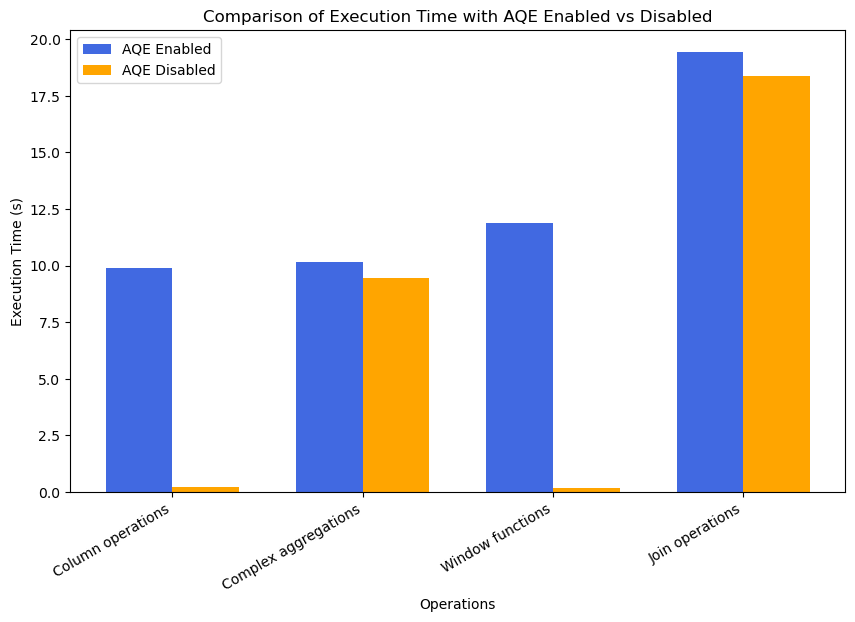

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract operation names and values dynamically
operations = list(aqe_enabled_results.keys())
values_enabled = list(aqe_enabled_results.values())
values_disabled = list(aqe_disabled_results.values())

# Create bar plot
x = np.arange(len(operations))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, values_enabled, width, label='AQE Enabled', color='royalblue')
rects2 = ax.bar(x + width/2, values_disabled, width, label='AQE Disabled', color='orange')

# Labels and formatting
ax.set_xlabel("Operations")
ax.set_ylabel("Execution Time (s)")
ax.set_title("Comparison of Execution Time with AQE Enabled vs Disabled")
ax.set_xticks(x)
ax.set_xticklabels(operations, rotation=30, ha="right")
ax.legend()

# Display plot
plt.show()


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, pandas_udf, col, avg
from pyspark.sql.types import IntegerType, StringType
import pandas as pd
import time

# 🚀 Optimized Spark Session
spark = SparkSession.builder \
    .appName("Spark3_PandasUDF_Test_Optimized") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

# 📌 Create a Dataset with 50K Rows
NUM_RECORDS = 50000
data = [(i, f"Name_{i}", i % 100, i % 5) for i in range(NUM_RECORDS)]
columns = ["id", "name", "value", "category"]
test_df = spark.createDataFrame(data, columns)

# ✅ Standard UDF Definitions
standard_double_udf = udf(lambda x: x * 2 if x is not None else 0, IntegerType())
standard_categorize_udf = udf(lambda x: "high" if x > 50 else "low", StringType())

# ✅ Optimized Pandas UDFs
@pandas_udf(IntegerType())
def pandas_double_udf(v: pd.Series) -> pd.Series:
    return v * 2

@pandas_udf(StringType())
def pandas_categorize_udf(v: pd.Series) -> pd.Series:
    return v.map(lambda x: "high" if x > 50 else "low")

# 📏 Function to Measure Execution Time
def measure_execution(operation_name, func):
    start_time = time.time()
    func()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"✅ {operation_name}: {execution_time:.4f} sec")
    return execution_time

# ✅ Test: Standard UDF Processing
execution_time_std = measure_execution(
    "Standard UDF processing",
    lambda: test_df.withColumn("doubled", standard_double_udf(col("value")))
                   .withColumn("category_label", standard_categorize_udf(col("value")))
                   .groupBy("category_label")
                   .agg(avg("doubled").alias("avg_doubled"))
                   .show(10, False)
)

# ✅ Test: Pandas UDF Processing
execution_time_pandas = measure_execution(
    "Pandas UDF processing",
    lambda: test_df.withColumn("doubled", pandas_double_udf(col("value")))
                   .withColumn("category_label", pandas_categorize_udf(col("value")))
                   .groupBy("category_label")
                   .agg(avg("doubled").alias("avg_doubled"))
                   .show(10, False)
)

# 📏 Measure Code Complexity
standard_udf_code = """
standard_double_udf = udf(lambda x: x * 2, IntegerType())
standard_categorize_udf = udf(lambda x: "high" if x > 50 else "low", StringType())

test_df = test_df.withColumn("doubled", standard_double_udf(col("value"))) \
                 .withColumn("category_label", standard_categorize_udf(col("value")))
"""

pandas_udf_code = """
@pandas_udf(IntegerType())
def pandas_double_udf(v: pd.Series) -> pd.Series:
    return v * 2

@pandas_udf(StringType())
def pandas_categorize_udf(v: pd.Series) -> pd.Series:
    return v.map(lambda x: "high" if x > 50 else "low")

test_df = test_df.withColumn("doubled", pandas_double_udf(col("value"))) \
                 .withColumn("category_label", pandas_categorize_udf(col("value")))
"""

print(f"📏 Standard UDF Code Complexity: {len(standard_udf_code.strip().splitlines())} lines")
print(f"📏 Pandas UDF Code Complexity: {len(pandas_udf_code.strip().splitlines())} lines")


+--------------+-----------+
|category_label|avg_doubled|
+--------------+-----------+
|high          |150.0      |
|low           |50.0       |
+--------------+-----------+

✅ Standard UDF processing: 17.3684 sec
+--------------+-----------+
|category_label|avg_doubled|
+--------------+-----------+
|high          |150.0      |
|low           |50.0       |
+--------------+-----------+

✅ Pandas UDF processing: 16.9369 sec
📏 Standard UDF Code Complexity: 4 lines
📏 Pandas UDF Code Complexity: 9 lines


In [ ]:
import time
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *

# Track metrics without sparkmeasure
def track_metrics(test_name, operation_func, code_snippet):
    # Time measurement
    start_time = time.time()
    result = operation_func()
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Count lines in code snippet
    line_count = len(code_snippet.strip().split('\n'))
    
    print(f"Test: {test_name}")
    print(f"  Execution time: {execution_time:.4f} seconds")
    print(f"  Code lines: {line_count}")
    
    return {
        "test_name": test_name,
        "spark_version": "3.x",
        "execution_time": execution_time,
        "code_lines": line_count
    }

# Create sample data
def create_test_data(size=50000):
    data = [(i, f"name_{i}", i % 100, i % 5) for i in range(size)]
    return spark.createDataFrame(data, ["id", "name", "value", "category"])

# Create test dataset
test_df = create_test_data()
metrics = []

# Test 1: DataFrame filtering and aggregation
test_1_code = """
filtered_df = test_df.filter(F.col("value") > 50)
result = filtered_df.groupBy("category") \
                   .agg(F.count("*").alias("count"), 
                        F.avg("value").alias("avg_value"),
                        F.sum("value").alias("sum_value")) \
                   .orderBy("category")
"""

metrics.append(track_metrics(
    "DataFrame filtering and aggregation",
    lambda: eval(compile(test_1_code, "<string>", "exec"), 
                {"test_df": test_df, "F": F}),
    test_1_code
))

# Test 2: Window functions
test_2_code = """
window_spec = Window.partitionBy("category").orderBy(F.desc("value"))
result = test_df.withColumn("rank", F.rank().over(window_spec)) \
               .filter(F.col("rank") <= 10) \
               .orderBy("category", "rank")
"""

metrics.append(track_metrics(
    "Window functions",
    lambda: eval(compile(test_2_code, "<string>", "exec"), 
                {"test_df": test_df, "F": F, "Window": Window}),
    test_2_code
))

# Test 3: Standard UDF in Spark 3.x
test_3_code = """
from pyspark.sql.functions import udf

double_value = udf(lambda x: x * 2, IntegerType())
categorize = udf(lambda x: "high" if x > 50 else "low", StringType())

result = test_df.withColumn("doubled", double_value(F.col("value"))) \
               .withColumn("category_text", categorize(F.col("value"))) \
               .groupBy("category_text") \
               .agg(F.avg("doubled").alias("avg_doubled"))
"""

metrics.append(track_metrics(
    "Standard UDF processing",
    lambda: eval(compile(test_3_code, "<string>", "exec"), 
                {"test_df": test_df, "F": F, "IntegerType": IntegerType, 
                 "StringType": StringType}),
    test_3_code
))

# Test 4: Pandas UDF (Spark 3.x only)
test_4_code = """
from pyspark.sql.functions import pandas_udf
import pandas as pd

@pandas_udf(IntegerType())
def pandas_double(s: pd.Series) -> pd.Series:
    return s * 2

@pandas_udf(StringType())
def pandas_categorize(s: pd.Series) -> pd.Series:
    return s.apply(lambda x: "high" if x > 50 else "low")

result = test_df.withColumn("doubled", pandas_double(F.col("value"))) \
               .withColumn("category_text", pandas_categorize(F.col("value"))) \
               .groupBy("category_text") \
               .agg(F.avg("doubled").alias("avg_doubled"))
"""

metrics.append(track_metrics(
    "Pandas UDF processing",
    lambda: eval(compile(test_4_code, "<string>", "exec"), 
                {"test_df": test_df, "F": F, "IntegerType": IntegerType, 
                 "StringType": StringType, "pd": pd}),
    test_4_code
))

# Save results
metrics_df = pd.DataFrame(metrics)
print("\nSpark 3.x Metrics Summary:")
print(metrics_df)
metrics_df.to_csv("spark3_metrics.csv", index=False)